# new One - Dev started 15/02/2023


In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import rand_score,adjusted_rand_score
from sklearn.cluster import KMeans
import statistics as s
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import statistics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (MinMaxScaler,
FunctionTransformer,
LabelBinarizer,
LabelEncoder,
OneHotEncoder,
OrdinalEncoder,
StandardScaler,
)
from sklearn import preprocessing
import re
import scienceplots

plt.style.use(['science','no-latex',"nature"])
#plt.style.use('science')


In [2]:
###variables
continuous_values = [
    "Age",
    "trestbps",
    "chol",
    "thalach",
    "oldpeak"
]
NA_REPLACE=["?"]

In [3]:
data=pd.read_table("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",sep=",",header=None)

cols=["Age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"]

NR_COLS=len(cols)
data.columns=cols
data.head(4)


,Age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0


In [4]:
# categorical variables are aprehend by difference
categorical_values = data[data.columns.difference(continuous_values)].columns

In [5]:
for col in NA_REPLACE:
    data.replace(col,np.nan,inplace=True)

In [6]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
x_cont=imp_mean.fit_transform(data[continuous_values])
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
x_cat=imp_mean.fit_transform(data[categorical_values])
data[continuous_values]=pd.DataFrame(x_cont,columns=continuous_values)
data[categorical_values]=pd.DataFrame(x_cat,columns=categorical_values)

In [7]:
# convert types
data[continuous_values] = data[continuous_values].astype("float64")
data[categorical_values] = data[categorical_values].astype("float64").astype(str)


In [8]:
silo1=data.iloc[:100,:]
silo2=data.iloc[100:200,:]
silo3=data.iloc[200:300,:]

## Distributed clustering

1. cada um inicializa  
1.1 ou com elementos tirados de uma distribuição com media igual a sua e desvio padrao x  
1.2 ou com proprios centroides  
1.3 ou com ruido nos dados e depois criar centroides  
2. cada um recebe os centroids e adiciona os seus proprios e a sua media (a media insere vies)  
3. repetir envio até:  
    3.1 medida de concordancia que é matrix confusão de todos os pares de pontos e cujo centroide estao associados   
    

In [9]:
# 1. cada um inicializa com os seus dados
def create_initializer_cat(data,cols,clusters):
    """
    initializer is creating a dummy centroid for initializing
    takes the data, uses it to create random noise and then adds it to the real clusters
    """
    res=[]
    for c in cols:
      #  print(c)
        prop=data[c].value_counts(normalize=True).values
        noise = np.random.normal(0,1)
        other_noise = np.random.normal(0,1)
        if other_noise<0:
          noised_init = np.add(prop, noise)  
        else:
          noised_init = np.add(prop, -noise)
        res.append(noised_init)
    return res

init_1=create_initializer_cat(silo1,["sex"],2) #1.1
init_2=create_initializer_cat(silo2,["sex"],2)
init_3=create_initializer_cat(silo3,["sex"],2)
print("init_1",init_1)
print("init_2",init_2)
print("init_3",init_3)

init_1 [array([2.12005603, 1.70005603])]
init_2 [array([1.03818289, 0.59818289])]
init_3 [array([0.63958063, 0.41958063])]


In [10]:
init_l_1=create_initializer_cat(silo1,["sex","cp"],2) #1.1
init_l_2=create_initializer_cat(silo2,["sex","cp"],2) #1.1
init_l_3=create_initializer_cat(silo3,["sex","cp"],2) #1.1
print("init_1",init_l_1)
print("init_2",init_l_2)
print("init_3",init_l_3)

init_1 [array([-0.07948682, -0.49948682]), array([-0.17823367, -0.27823367, -0.49823367, -0.55823367])]
init_2 [array([0.93214863, 0.49214863]), array([0.58239279, 0.38239279, 0.28239279, 0.20239279])]
init_3 [array([-0.29309822, -0.51309822]), array([-1.33144216, -1.61144216, -1.65144216, -1.77144216])]


In [11]:
#2. cada um recebe os centroids e adiciona os seus proprios e a sua media (a media insere vies)  
def calculate_centroids_cat(seeds,data,cols,clusters):
    """
    with data, calculates own mean and centroids and add to data:= centroids from the rest 
    """
    results=[]
    for idx,c in enumerate(cols):
        print(idx)
        my_porp=data[c].value_counts(normalize=True).values
        other_seeds=[item[idx] for item in seeds]

        real_centroids=KMeans(n_clusters=clusters,n_init=10, random_state=0).fit(data[c].values.reshape(-1, 1))
#        print("real",real_centroids.cluster_centers_.flatten())

    #    print("my",my_porp)
    #    print("other:seed",other_seeds)
        other_seed_flat=[item for sublist in other_seeds for item in sublist]
     #   print(other_seed_flat)
        final_list_data=np.concatenate((other_seed_flat,real_centroids.cluster_centers_.flatten()),axis=0) #add real centroids

        res=KMeans(n_clusters=clusters,n_init=10, random_state=0).fit(final_list_data.reshape(-1, 1)) #calculate new centroids
        results.append(res.cluster_centers_.flatten())
    return results

c1=calculate_centroids_cat([init_l_2,init_l_3],silo1,["sex","cp"],2)
c2=calculate_centroids_cat([init_l_1,init_l_3],silo2,["sex","cp"],2)
c3=calculate_centroids_cat([init_l_1,init_l_2],silo3,["sex","cp"],2)
print("c1",c1)
print("c2",c2)
print("c3",c3)


0
1
0
1
0
1
c1 [array([-0.26873215,  0.80809909]), array([-1.59144216,  1.11034519])]
c2 [array([ 1.        , -0.27703402]), array([-0.98483792,  2.64449064])]
c3 [array([-0.19299121,  0.80809909]), array([-0.00792044,  2.70997921])]


In [12]:
init_l__1=create_initializer_cat(silo1,["sex","cp","restecg"],2) #1.1
init_l__2=create_initializer_cat(silo2,["sex","cp","restecg"],2) #1.1
init_l__3=create_initializer_cat(silo3,["sex","cp","restecg"],2) #1.1
print("init_1",init_l__1)
print("init_2",init_l__2)
print("init_3",init_l__3)

init_1 [array([0.42667415, 0.00667415]), array([-0.90419471, -1.00419471, -1.22419471, -1.28419471]), array([1.35436934, 1.21436934])]
init_2 [array([-0.99778957, -1.43778957]), array([-1.11593626, -1.31593626, -1.41593626, -1.49593626]), array([-0.91745488, -1.03745488])]
init_3 [array([-0.73037454, -0.95037454]), array([2.07481674, 1.79481674, 1.75481674, 1.63481674]), array([3.10264534, 2.82264534, 2.52264534])]


In [13]:
c1=calculate_centroids_cat([init_l__2,init_l__3],silo1,["sex","cp","restecg"],2)
c2=calculate_centroids_cat([init_l__1,init_l__3],silo2,["sex","cp","restecg"],2)
c3=calculate_centroids_cat([init_l__1,init_l__2],silo3,["sex","cp","restecg"],2)
print("c1",c1)
print("c2",c2)
print("c3",c3)

0
1
2
0
1
2
0
1
2
c1 [array([ 0.5       , -1.02908205]), array([ 2.07862783, -1.33593626]), array([ 2.61198401, -0.65163659])]
c2 [array([ 0.35833707, -0.84037454]), array([ 2.09137471, -1.10419471]), array([2.61198401, 0.85624622])]
c3 [array([ 0.35833707, -1.21778957]), array([-1.22006548,  2.70997921]), array([ 1.48782517, -0.65163659])]


In [14]:
#3. 
def calculate_centroids_and_score_cat(clusters,other_centroids,mydata,cols,old_preds=None):

  newcs=[]
  preds=[]
  scores=[]
  c1=calculate_centroids_cat(other_centroids,mydata,cols,clusters)
 # print(c1)
  print(other_centroids)
  for idx,c in enumerate(c1):
   # print(c)
   # print(idx)
    kmm1_=KMeans(n_clusters=clusters,n_init=10, random_state=0).fit(c.reshape(-1, 1))
    ll=mydata[cols[idx]]
  #  print(ll)
    pred=kmm1_.predict(np.array(ll.values.reshape(-1, 1)))
   # print(pred)
    new_c=kmm1_.cluster_centers_.flatten()
    newcs.append(new_c)
    preds.append(pred)
    if old_preds is not None: #first round
    #  print(old_preds)
      scores.append(rand_score(pred,old_preds[idx]))
    
  return newcs,preds,scores


In [15]:
init_l_2

[array([0.93214863, 0.49214863]),
 array([0.58239279, 0.38239279, 0.28239279, 0.20239279])]

In [16]:
xx,_,_=calculate_centroids_and_score_cat(2,[init_l_2,init_l_3],silo1,["sex","cp"])
xx

0
1
[[array([0.93214863, 0.49214863]), array([0.58239279, 0.38239279, 0.28239279, 0.20239279])], [array([-0.29309822, -0.51309822]), array([-1.33144216, -1.61144216, -1.65144216, -1.77144216])]]


[array([-0.26873215,  0.80809909]), array([-1.59144216,  1.11034519])]

In [17]:
#3. repetir envio até:  
#    3.1 medida de concordancia que é matrix confusão de todos os pares de pontos e cujo centroide estao associados   

def mock_data_transfer_and_convergence(limit_after_convergence,threshold,cols_used,clusters=2):
    c1=create_initializer_cat(silo1,cols_used,clusters) 
    c2=create_initializer_cat(silo2,cols_used,clusters)
    c3=create_initializer_cat(silo3,cols_used,clusters)
    print("inits; ",c1,c2,c3)
    if len(c1)!=len(cols_used):
        raise Exception("wrong number of centroids")
    old_preds_1=old_preds_2=old_preds_3=None
    last_significance_round=0

    while  last_significance_round<limit_after_convergence:
        nc1,old_preds_1,score_1=calculate_centroids_and_score_cat(clusters=clusters,other_centroids=[c2,c3],mydata=silo1,cols=cols_used,old_preds=old_preds_1)
        nc2,old_preds_2,score_2=calculate_centroids_and_score_cat(clusters=clusters,other_centroids=[c1,c3],mydata=silo2,cols=cols_used,old_preds=old_preds_2)
        nc3,old_preds_3,score_3=calculate_centroids_and_score_cat(clusters=clusters,other_centroids=[c1,c2],mydata=silo3,cols=cols_used,old_preds=old_preds_3)
        print("nc1",nc1)
        if len(nc1)!=len(cols_used):
            raise Exception("wrong number of centroids")
      #  c1=[item for sublist in nc1 for item in sublist]
      #  c2=[item for sublist in nc2 for item in sublist]
      #  c3=[item for sublist in nc3 for item in sublist]
#       print("c1",c1)
  #      print("c2",c2)
    #    print("c3",c3)
        c1=nc1
        c2=nc2
        c3=nc3
        if all([s>threshold for s  in  score_1]) and all([s>threshold for s  in  score_2]) and all([s>threshold for s  in  score_3]):
            last_significance_round+=1
        else:
            last_significance_round=0
    return nc1,nc2,nc3

In [18]:
f1,f2,f3=mock_data_transfer_and_convergence(20,0.9,["sex","cp","restecg"])

inits;  [array([-0.00214274, -0.42214274]), array([-0.2044637, -0.3044637, -0.5244637, -0.5844637]), array([0.65445425, 0.51445425])] [array([1.29960924, 0.85960924]), array([-0.43400956, -0.63400956, -0.73400956, -0.81400956]), array([0.87114362, 0.75114362])] [array([1.1391484, 0.9191484]), array([-0.97198321, -1.25198321, -1.29198321, -1.41198321]), array([-1.2135766, -1.4935766, -1.7935766])]
0
1
2
[[array([1.29960924, 0.85960924]), array([-0.43400956, -0.63400956, -0.73400956, -0.81400956]), array([0.87114362, 0.75114362])], [array([1.1391484, 0.9191484]), array([-0.97198321, -1.25198321, -1.29198321, -1.41198321]), array([-1.2135766, -1.4935766, -1.7935766])]]
0
1
2
[[array([-0.00214274, -0.42214274]), array([-0.2044637, -0.3044637, -0.5244637, -0.5844637]), array([0.65445425, 0.51445425])], [array([1.1391484, 0.9191484]), array([-0.97198321, -1.25198321, -1.29198321, -1.41198321]), array([-1.2135766, -1.4935766, -1.7935766])]]
0
1
2
[[array([-0.00214274, -0.42214274]), array([-0

In [19]:
f1

[array([-1.26019528e-05,  1.00000517e+00]),
 array([ 2.63464397, -0.76348553]),
 array([ 1.97352745e+00, -2.00518311e-04])]

In [20]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)

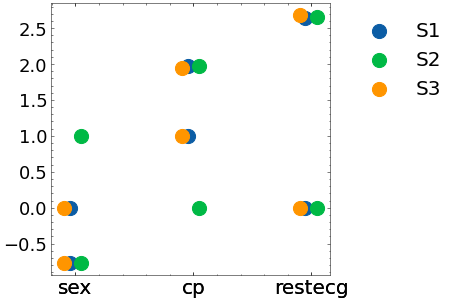

In [23]:
# plot
xlabel=["sex","cp","restecg","sex","cp","restecg"]
# plot
x=[1,2,3,1,2,3]
#c1=plt.scatter(x,kmm3_.cluster_centers_)
c2=plt.scatter([x-0.05 for x in x],f1,s=200)
c3=plt.scatter([x+0.05 for x in x],f2,s=200)
c4=plt.scatter([x-0.10 for x in x],f3,s=200)
#c5=plt.scatter([1.10,2.10,3.10],silo2[["Age","trestbps","chol"]].mean().values)


lgd=plt.legend(( c2,c3,c4),
           ( 'S1',"S2","S3"),
           scatterpoints=1,
         #  loc=5,
           fontsize=20,bbox_to_anchor=(1.04, 1.))
plt.xticks(x, xlabel)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)
plt.savefig("Vizs/my_cluster_3_cat.png",bbox_extra_artists=(lgd,), bbox_inches='tight')
#jitter - ver chatgpt